# Color Detection and Thresholding
In this notebook I've focused on the color detection and thresholding, leaving the line detection for later.

In [429]:
# Set the right working folder to root folder of the project
import os

print("Looking for root folder of the project...")
for folder_depth in range(100): 
    if os.path.exists(".git"):
        root_folder = os.getcwd()
        print("Root folder found. Now working in directory '%s'" % os.getcwd())
        break
    else:
        print("Going up from '%s'" % os.getcwd())
        os.chdir("..")
else:
    raise Exception("Root folder of the project not found. Terminating.")
    

Looking for root folder of the project...
Root folder found. Now working in directory 'C:\Users\linas\projects\CarND-Advanced-Lane-Lines'


In [430]:
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import numpy as np
from math import ceil


class Plotter:
    def __init__(self, columns, figsize=(20, 40)):
        plt.figure(figsize=figsize)
        
        self.columns = columns
        self.images = []
        
    def add_img(self, img, title):
        assert len(img.shape) == 2 or img.shape[2] == 3
        
        cmap = None
        if len(img.shape) == 2:
            cmap = "gray"
            
        self.images.append((img, title, cmap))
            
    def plot(self):
        j = 1  # Current column
        i = 0
        rows = ceil(len(self.images) // self.columns)
        for img, title, cmap in self.images:
            ax = plt.subplot((rows / self.columns + 1) * self.columns, self.columns, i * self.columns + j)
            ax.set_title(title)
            plt.imshow(img, cmap="gray")
            
            if j % self.columns == 0:
                j = 0
                i += 1
            j += 1


In [433]:
import numpy as np
import cv2

def apply_precomputed_undistortion(img, mtx_filename, dist_filename):
    mtx = np.load(mtx_filename)
    dist = np.load(dist_filename)
    undist_img = cv2.undistort(img, mtx, dist)
    return undist_img

### Color thresholding in problematic images
I'll start by creating a processing function for images. This will later be applied to the videos as in the first project.

#### Color space test
I shall first plot all three channels of the HLS image to see which ones work the best.

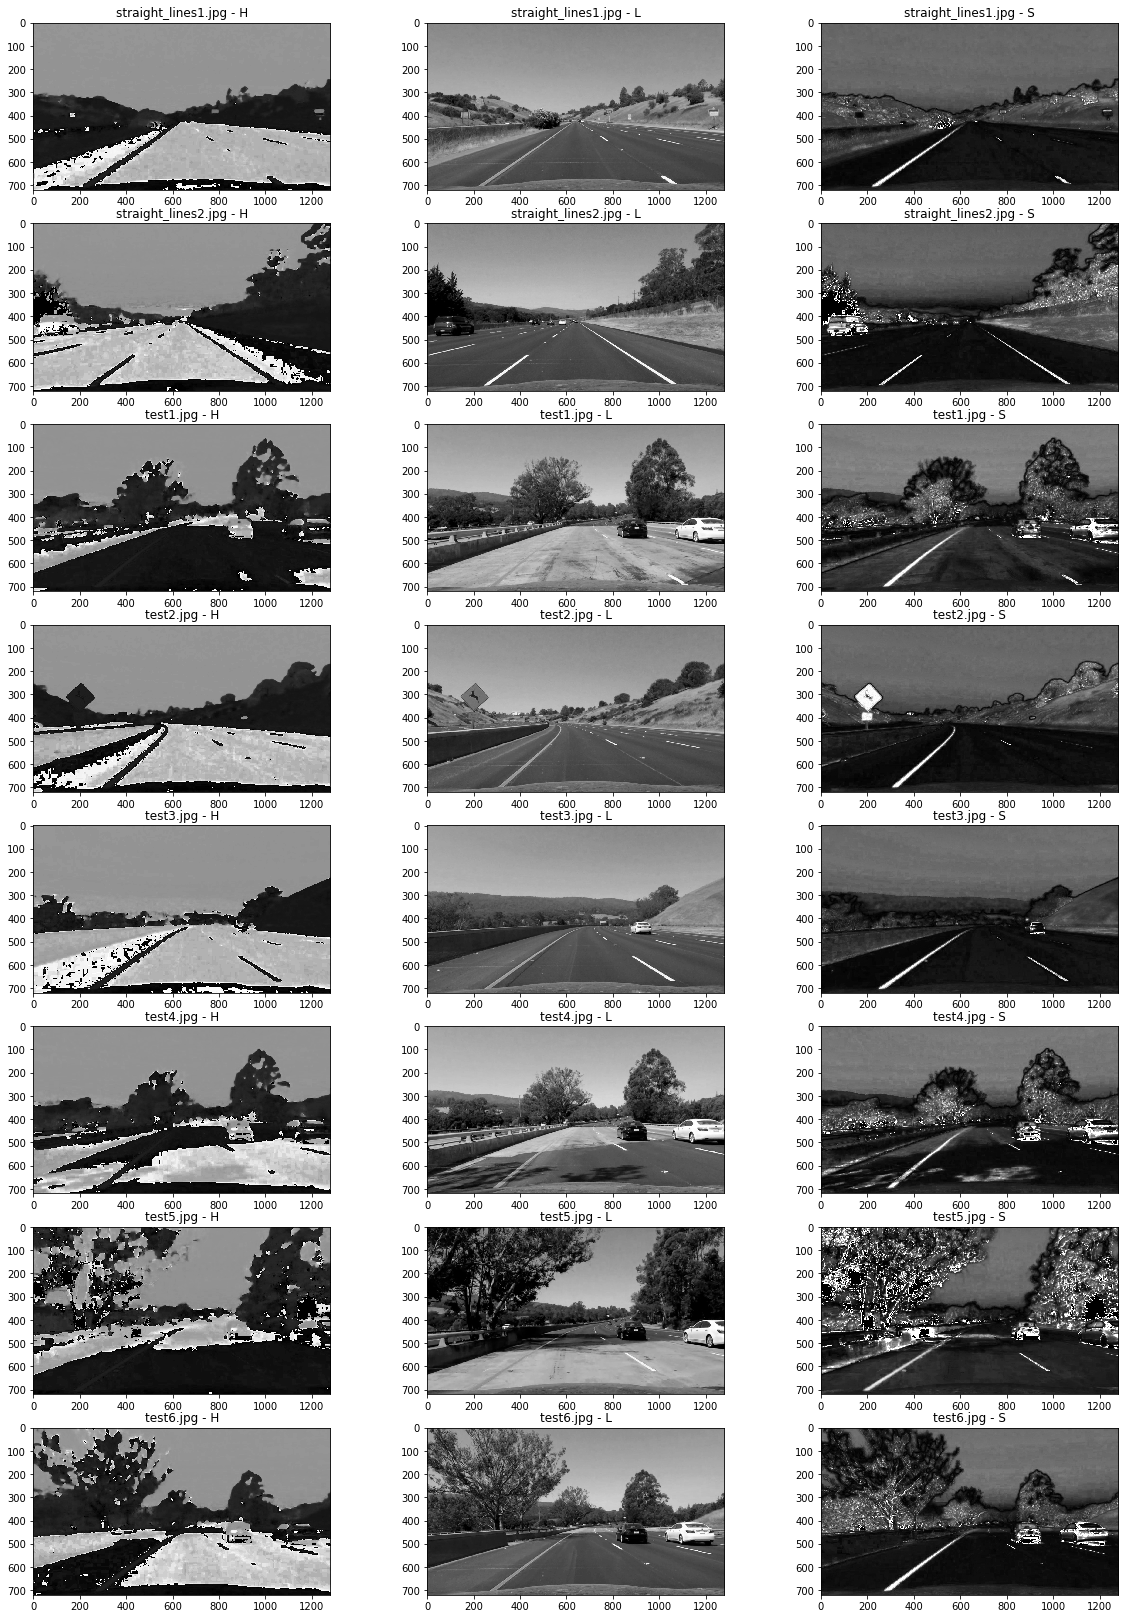

In [416]:
image_path_pattern = os.path.join(root_folder, "data", "test_images", "*.jpg")
image_fnames = glob.glob(image_path_pattern)

plotter = Plotter(columns=3, figsize=(20, 40))

for i, img_fname in enumerate(image_fnames):
    img = mpimg.imread(img_fname)
    
    # Undistort Image
    mtx_filename  = os.path.join(root_folder, "params", "camera_matrix.npy")
    dist_filename = os.path.join(root_folder, "params", "dist_coeffs.npy")
    img = apply_precomputed_undistortion(img, mtx_filename, dist_filename)

    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls_img[:, :, 0]
    l_channel = hls_img[:, :, 1]
    s_channel = hls_img[:, :, 2]
    
    plotter.add_img(h_channel, "%s - H" % os.path.basename(img_fname))
    plotter.add_img(l_channel, "%s - L" % os.path.basename(img_fname))
    plotter.add_img(s_channel, "%s - S" % os.path.basename(img_fname))

plotter.plot()
    

As in the classes before, we can see that the S channel outperforms others. We'll use it for now. Just in case, lets see some binary thresholding first.

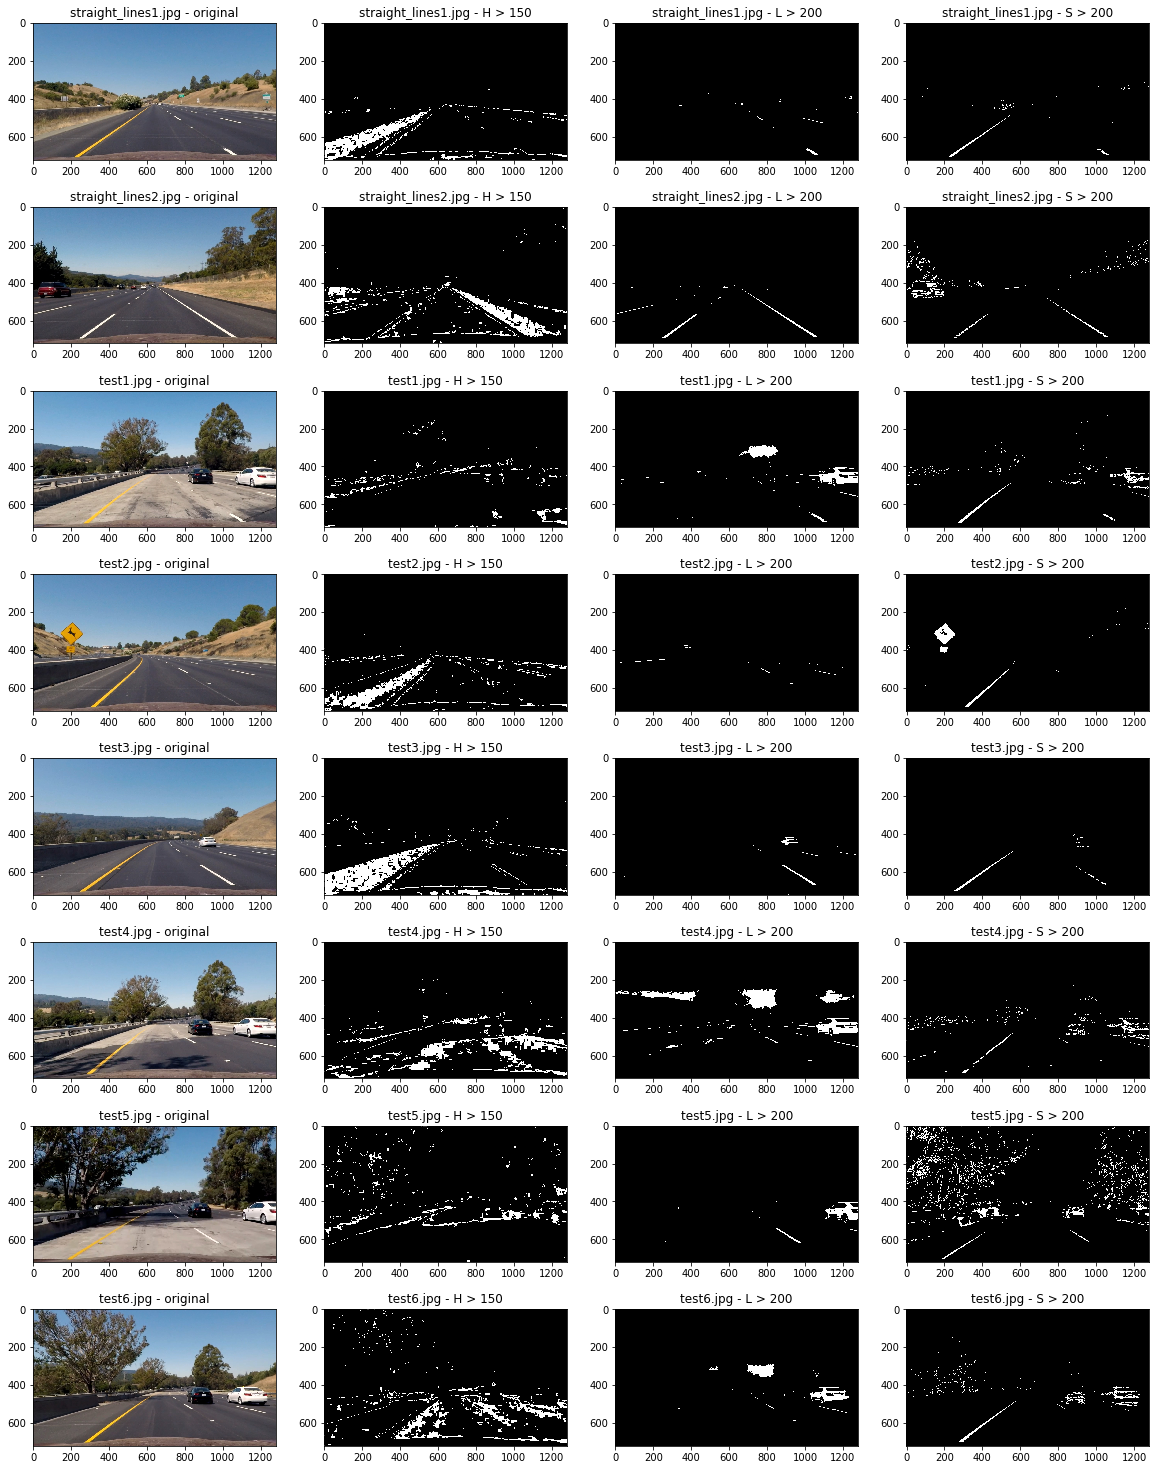

In [420]:
image_path_pattern = os.path.join(root_folder, "data", "test_images", "*.jpg")
image_fnames = glob.glob(image_path_pattern)

plotter = Plotter(columns=4, figsize=(20, 40))

for k, img_fname in enumerate(image_fnames):
    img = mpimg.imread(img_fname)
    
    # Undistort Image
    mtx_filename  = os.path.join(root_folder, "params", "camera_matrix.npy")
    dist_filename = os.path.join(root_folder, "params", "dist_coeffs.npy")
    img = apply_precomputed_undistortion(img, mtx_filename, dist_filename)
    
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls_img[:, :, 0]
    l_channel = hls_img[:, :, 1]
    s_channel = hls_img[:, :, 2]
    
    h_thresh_value = 150
    h_thresh = np.zeros_like(h_channel)
    h_thresh[h_channel > h_thresh_value] = 1
    
    l_thresh_value = 200
    l_thresh = np.zeros_like(l_channel)
    l_thresh[l_channel > l_thresh_value] = 1
    
    s_thresh_value = 200
    s_thresh = np.zeros_like(s_channel)
    s_thresh[s_channel > s_thresh_value] = 1
    
    plotter.add_img(img,      "%s - original" % os.path.basename(img_fname))
    plotter.add_img(h_thresh, "%s - H > %d" % (os.path.basename(img_fname), h_thresh_value))
    plotter.add_img(l_thresh, "%s - L > %d" % (os.path.basename(img_fname), l_thresh_value))
    plotter.add_img(s_thresh, "%s - S > %d" % (os.path.basename(img_fname), s_thresh_value))
    
plotter.plot()


I can see the lines in all cases of the S threshold, but the sky is picked up as well, in all cases. Lets see if I can combine it with edge detection. If not, maybe I'll check the conventional color channels for inspiration.

#### Edge detection
In this part I'll try to use edges to see the lane lines, combining the two approaches in the next part.

First, just in case, lets check how the RGB color channels look like. Maybe we can stick to the best when carrying out Edge Detection.

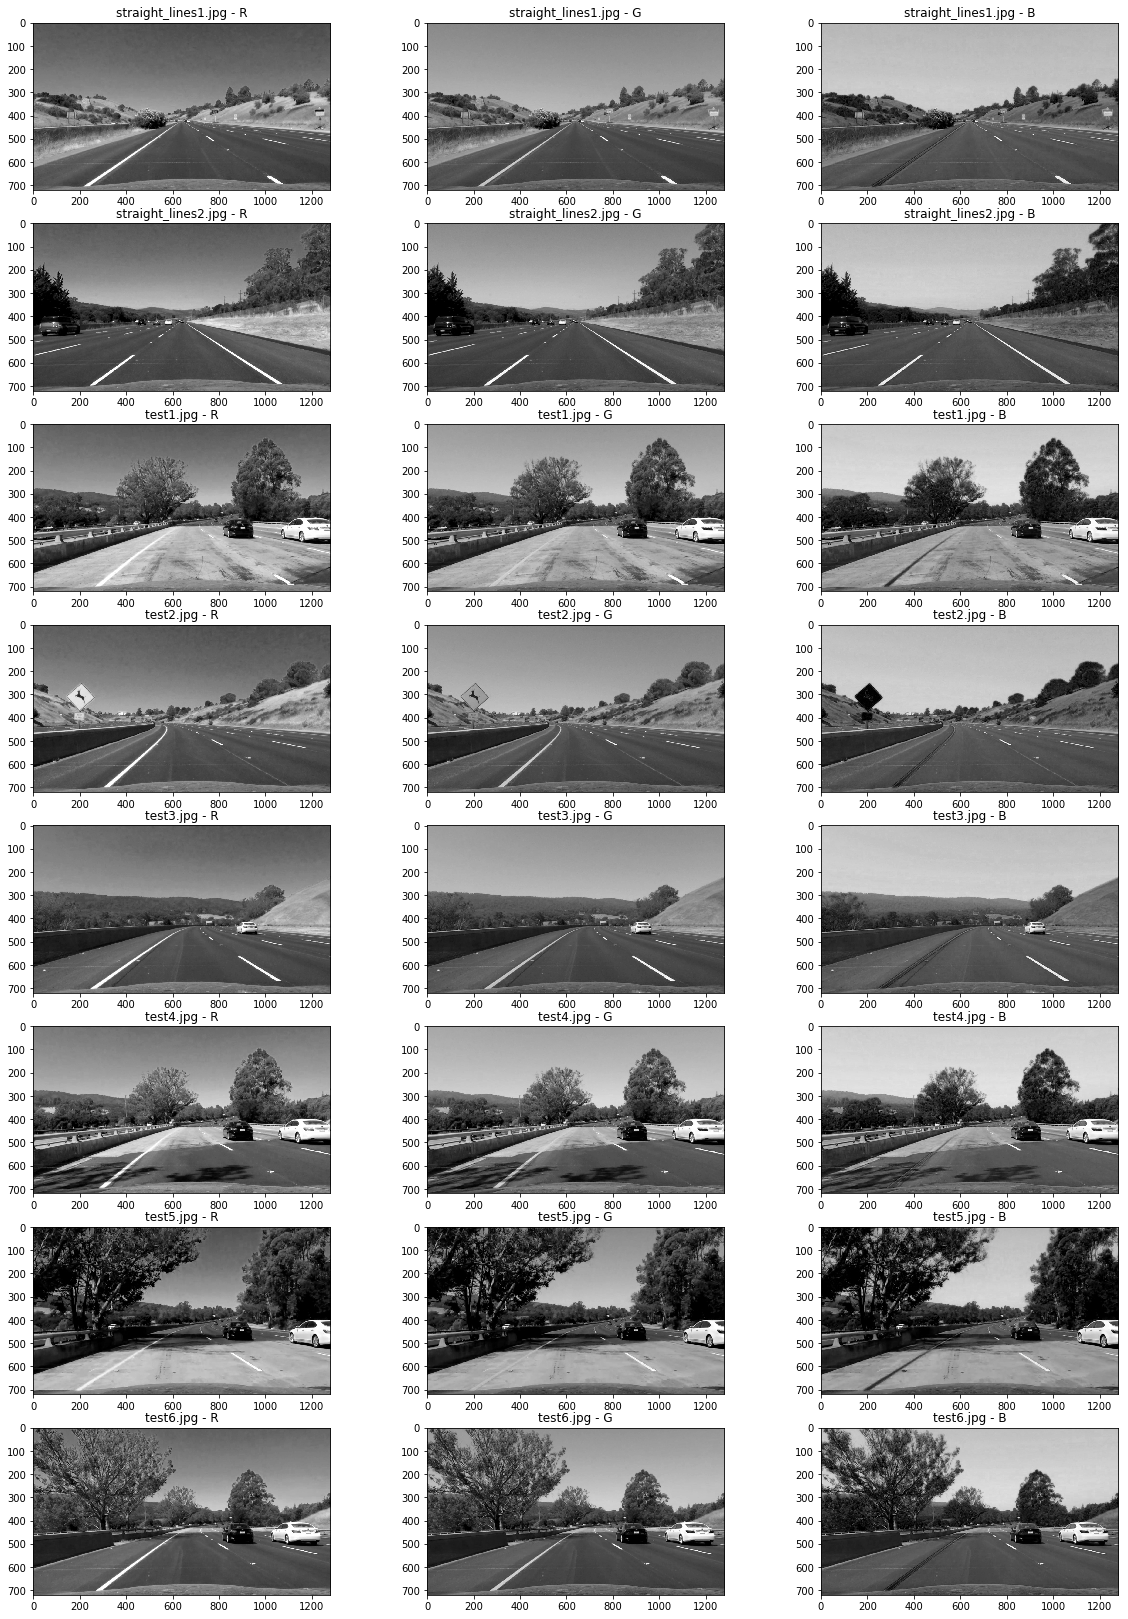

In [424]:
image_path_pattern = os.path.join(root_folder, "data", "test_images", "*.jpg")
image_fnames = glob.glob(image_path_pattern)

plotter = Plotter(columns=3, figsize=(20, 40))

for i, img_fname in enumerate(image_fnames):
    img = mpimg.imread(img_fname)
    
    # Undistort Image
    mtx_filename  = os.path.join(root_folder, "params", "camera_matrix.npy")
    dist_filename = os.path.join(root_folder, "params", "dist_coeffs.npy")
    img = apply_precomputed_undistortion(img, mtx_filename, dist_filename)
    
    r_channel = img[:, :, 0]
    g_channel = img[:, :, 1]
    b_channel = img[:, :, 2]
    
    plotter.add_img(r_channel, "%s - R" % os.path.basename(img_fname))
    plotter.add_img(g_channel, "%s - G" % os.path.basename(img_fname))
    plotter.add_img(b_channel, "%s - B" % os.path.basename(img_fname))

plotter.plot()
    

As in the course videos, R outperforms others. In fact, I've already experimented with edge detection at this point and found it lacking, when applied to normal grayscaled images. So lets see if I can make it work by only using the red channel.

After an investigation of the gradient magnitude and the gradient direction, I believe that it would be beneficial to investigate them separately, develop two optimistic thresholding methods, and take their overlap as the final edges found. Then, we can make a disjunction with the color threshold for the final thresholding. 

##### Gradient Magnitude
I am going to compare sets of hyperparameters together, to find a good optimistic thresholding method.

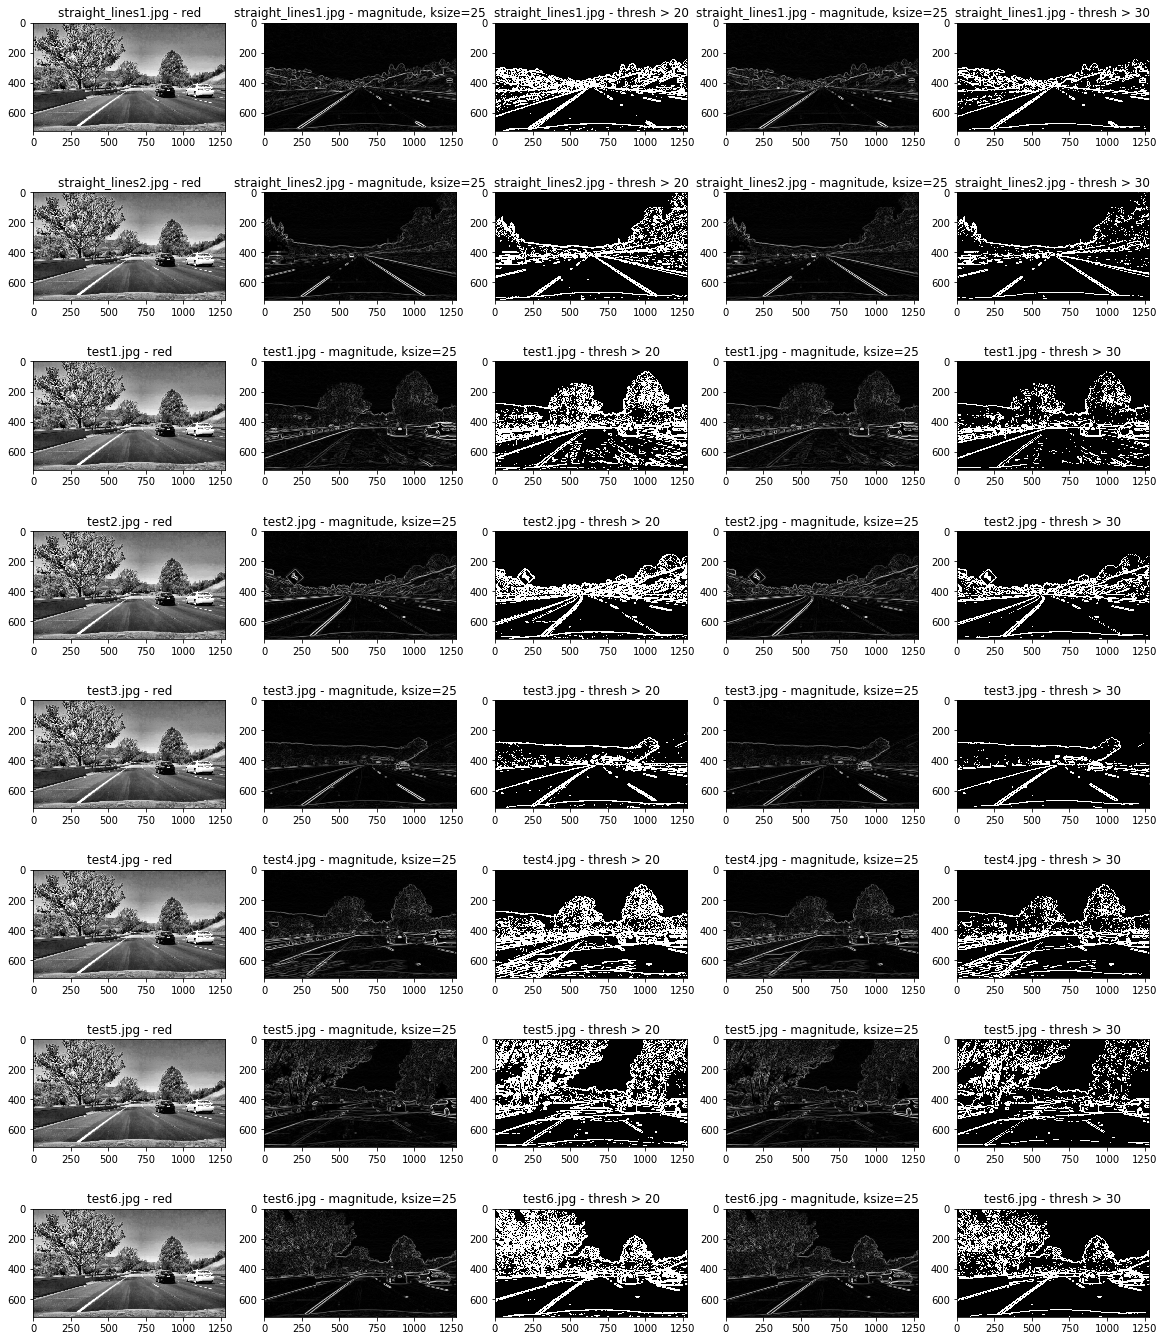

In [428]:
image_path_pattern = os.path.join(root_folder, "data", "test_images", "*.jpg")
image_fnames = glob.glob(image_path_pattern)

plotter = Plotter(columns=5, figsize=(20, 40))

for i, img_fname in enumerate(image_fnames):
    img = mpimg.imread(img_fname)
    
    # Undistort Image
    mtx_filename  = os.path.join(root_folder, "params", "camera_matrix.npy")
    dist_filename = os.path.join(root_folder, "params", "dist_coeffs.npy")
    img = apply_precomputed_undistortion(img, mtx_filename, dist_filename)    
    
    red = img[:, :, 0]
    plotter.add_img(cl1, "%s - red" % os.path.basename(img_fname))
    
    # Set 1
    sobel_kernel = 25
    assert sobel_kernel >= 3 and sobel_kernel % 2 == 1
    sobel_x = cv2.Sobel(red, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(red, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    sobel_x = np.absolute(sobel_x)
    sobel_y = np.absolute(sobel_y)

    magnitude = (sobel_x**2 + sobel_y**2)**.5
    mag_norm = np.uint8(255 * magnitude / np.max(magnitude))
    mag_thresh_value = 20
    mag_thresh = np.zeros_like(mag_norm)
    mag_thresh[mag_norm > mag_thresh_value] = 1
    
    plotter.add_img(magnitude,  "%s - magnitude, ksize=%d" % (os.path.basename(img_fname), sobel_kernel))
    plotter.add_img(mag_thresh, "%s - thresh > %d" % (os.path.basename(img_fname), mag_thresh_value))
    
    
    # Set 2
    sobel_kernel = 25
    assert sobel_kernel >= 3 and sobel_kernel % 2 == 1
    sobel_x = cv2.Sobel(red, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(red, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    sobel_x = np.absolute(sobel_x)
    sobel_y = np.absolute(sobel_y)

    magnitude = (sobel_x**2 + sobel_y**2)**.5
    mag_norm = np.uint8(255 * magnitude / np.max(magnitude))
    mag_thresh_value = 30
    mag_thresh = np.zeros_like(mag_norm)
    mag_thresh[mag_norm > mag_thresh_value] = 1
    
    plotter.add_img(magnitude,  "%s - magnitude, ksize=%d" % (os.path.basename(img_fname), sobel_kernel))
    plotter.add_img(mag_thresh, "%s - thresh > %d" % (os.path.basename(img_fname), mag_thresh_value))
    
plotter.plot()


Ultimately, I found a good kernel size to be `25` and the minimum magnitude threshold of `20`. It produces a nice, optimistic thresholding now, but might need to be calibrated in the future.

##### Gradient Direction
Here I'll investigate the gradient direction for thresholding.

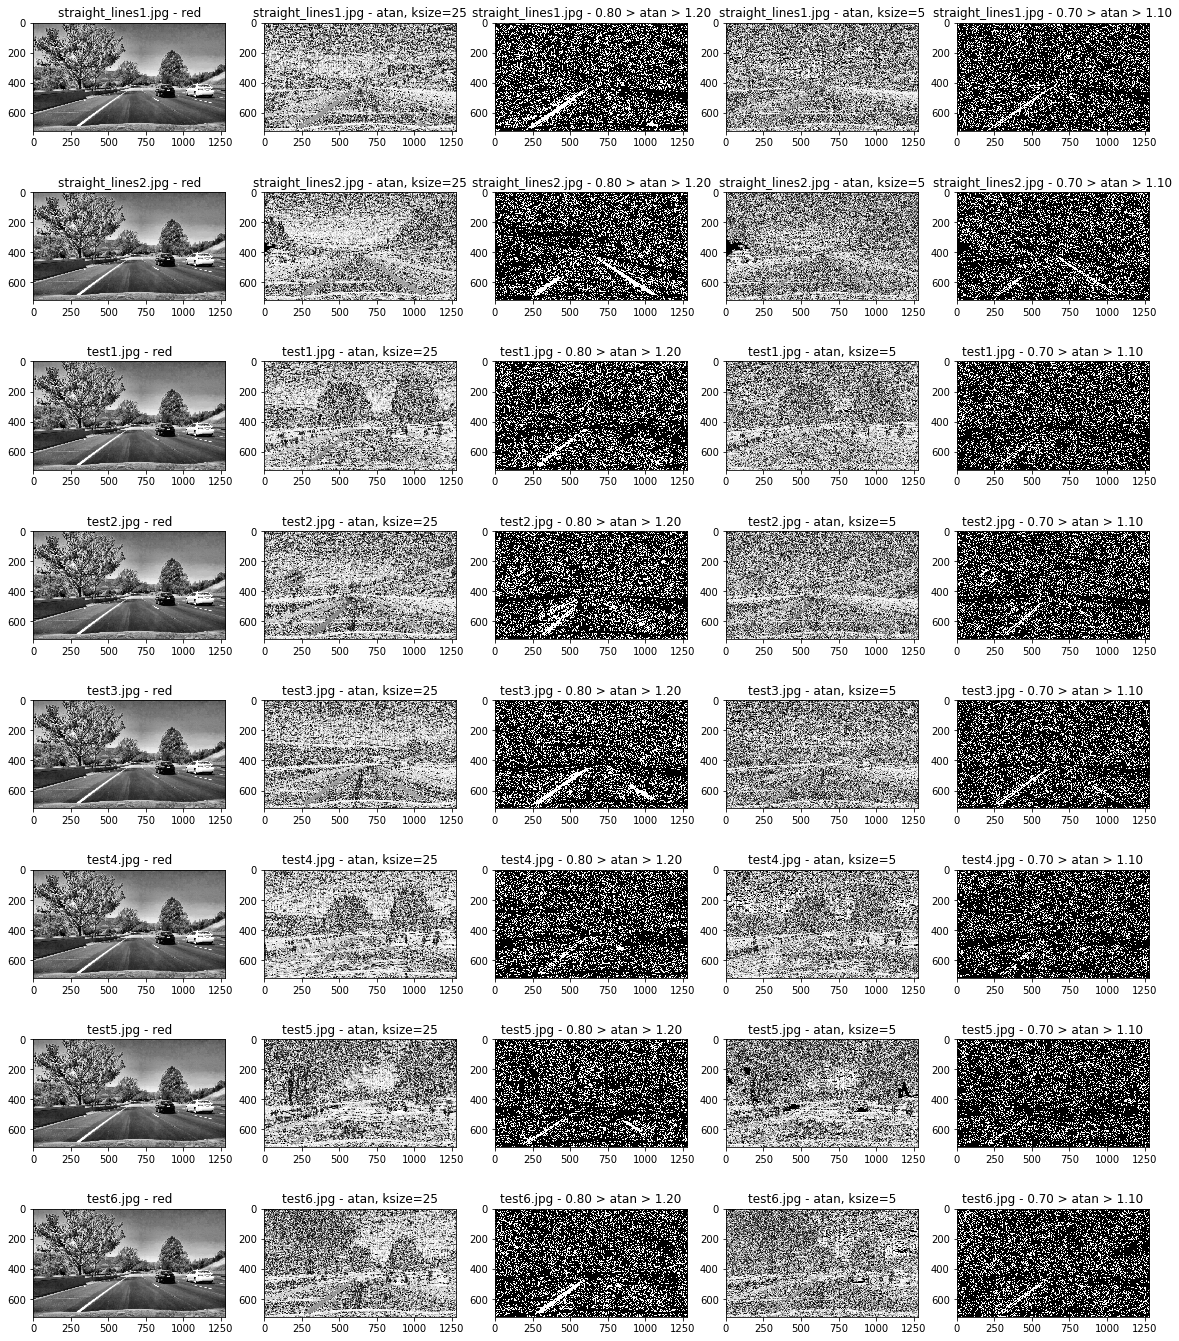

In [432]:
image_path_pattern = os.path.join(root_folder, "data", "test_images", "*.jpg")
image_fnames = glob.glob(image_path_pattern)

plotter = Plotter(columns=5, figsize=(20, 40))

for i, img_fname in enumerate(image_fnames):
    img = mpimg.imread(img_fname)
    
    # Undistort Image
    mtx_filename  = os.path.join(root_folder, "params", "camera_matrix.npy")
    dist_filename = os.path.join(root_folder, "params", "dist_coeffs.npy")
    img = apply_precomputed_undistortion(img, mtx_filename, dist_filename)
    
    red = img[:, :, 0]
    plotter.add_img(cl1, "%s - red" % os.path.basename(img_fname))
    
    # Set 1
    sobel_kernel = 25
    assert sobel_kernel >= 3 and sobel_kernel % 2 == 1
    sobel_x = cv2.Sobel(red, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(red, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    sobel_x = np.absolute(sobel_x)
    sobel_y = np.absolute(sobel_y)

    atan = np.arctan2(sobel_y, sobel_x)
    atan_thresh_min = 0.8
    atan_thresh_max = 1.2
    atan_max = np.max(atan)
    atan_plot = np.uint8(255 * atan / atan_max)
    
    thresh = np.zeros_like(atan)
    thresh[(atan > atan_thresh_min) & (atan <= atan_thresh_max)] = 1
    
    plotter.add_img(atan_plot, "%s - atan, ksize=%d" % (os.path.basename(img_fname), sobel_kernel))
    plotter.add_img(thresh,    "%s - %.2f > atan > %.2f" % (os.path.basename(img_fname), atan_thresh_min, atan_thresh_max))
    
    
    # Set 2
    sobel_kernel = 5
    assert sobel_kernel >= 3 and sobel_kernel % 2 == 1
    sobel_x = cv2.Sobel(red, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(red, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    sobel_x = np.absolute(sobel_x)
    sobel_y = np.absolute(sobel_y)

    atan = np.arctan2(sobel_y, sobel_x)
    atan_thresh_min = 0.7
    atan_thresh_max = 1.1
    atan_max = np.max(atan)
    atan_plot = np.uint8(255 * atan / atan_max)
    
    thresh = np.zeros_like(atan)
    thresh[(atan > atan_thresh_min) & (atan <= atan_thresh_max)] = 1
    
    plotter.add_img(atan_plot, "%s - atan, ksize=%d" % (os.path.basename(img_fname), sobel_kernel))
    plotter.add_img(thresh,    "%s - %.2f > atan > %.2f" % (os.path.basename(img_fname), atan_thresh_min, atan_thresh_max))
    
plotter.plot()


I've got some results from directional gradient, but I don't feel fully satisfied. I've even tried to remove the noise by performing the `open` morphological transformation, but I'm not convinced it'll be needed, since I'll be intersecting the results of this with the magnitude.

##### Combining gradient magnitude and direction

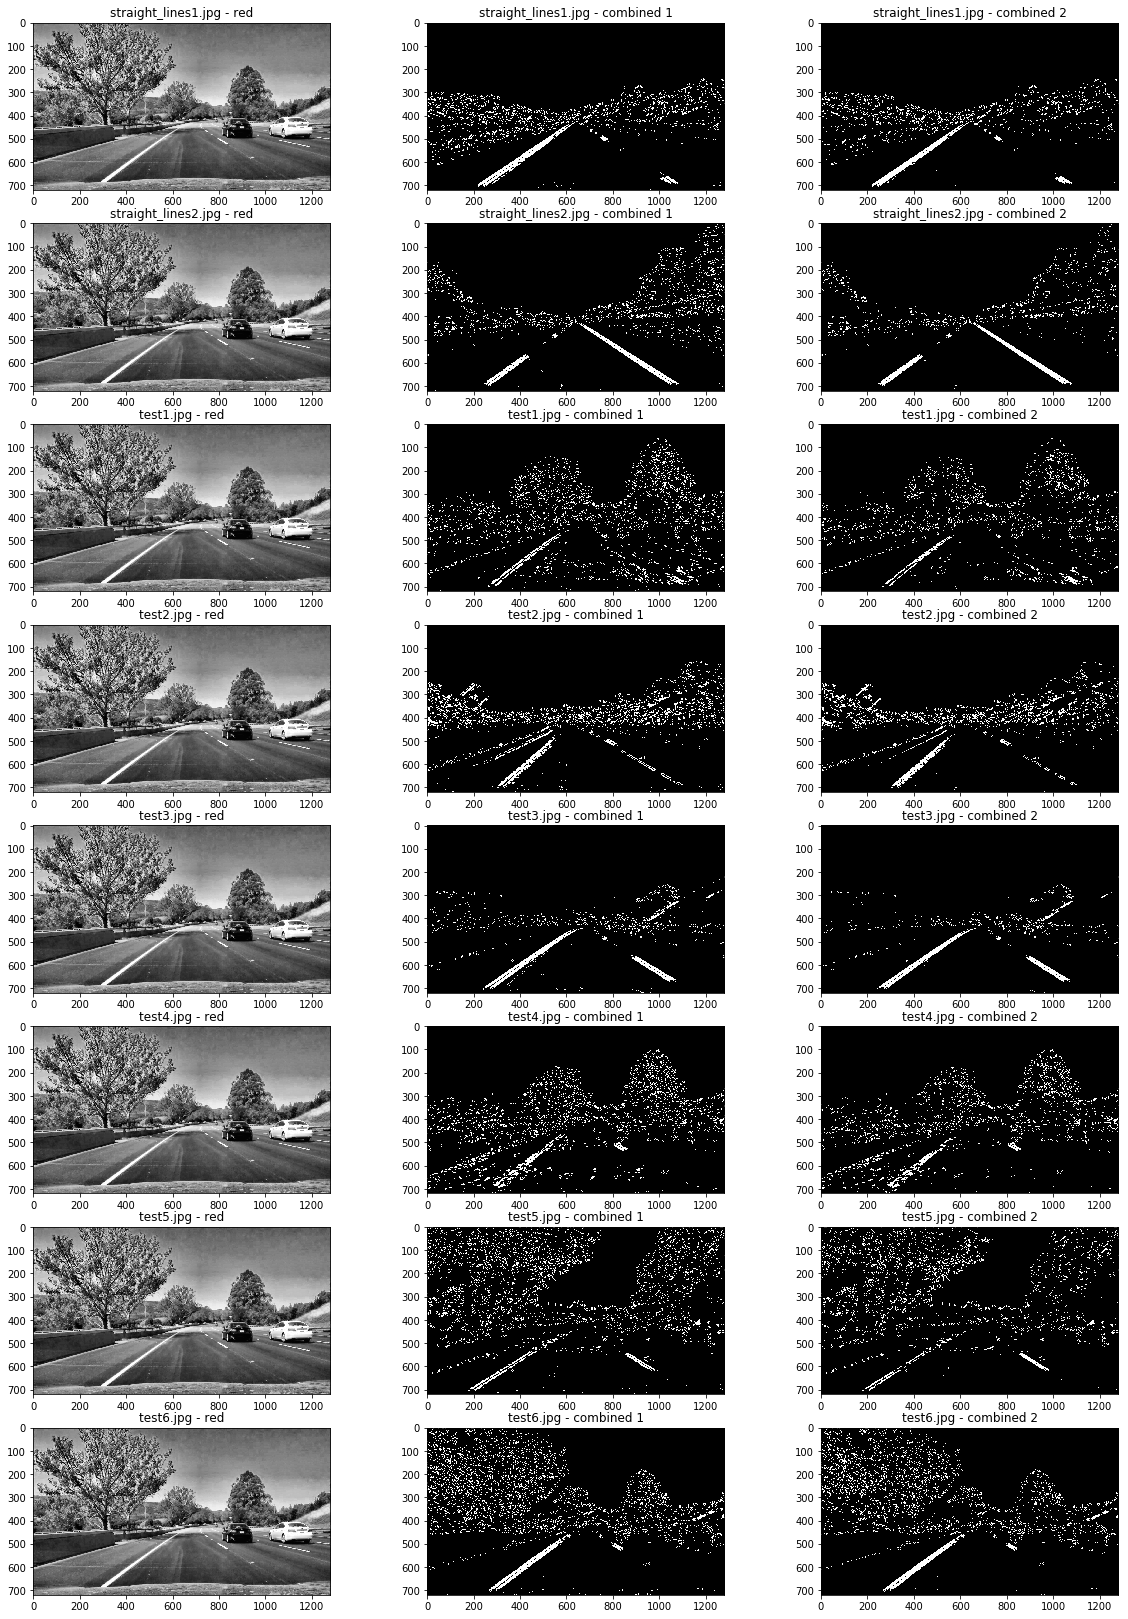

In [434]:
image_path_pattern = os.path.join(root_folder, "data", "test_images", "*.jpg")
image_fnames = glob.glob(image_path_pattern)

plotter = Plotter(columns=3, figsize=(20, 40))

for i, img_fname in enumerate(image_fnames):
    img = mpimg.imread(img_fname)

    # Undistort Image
    mtx_filename  = os.path.join(root_folder, "params", "camera_matrix.npy")
    dist_filename = os.path.join(root_folder, "params", "dist_coeffs.npy")
    img = apply_precomputed_undistortion(img, mtx_filename, dist_filename)
        
    red = img[:, :, 0]
    plotter.add_img(cl1, "%s - red" % os.path.basename(img_fname))
    
    # Set 1
    sobel_kernel = 25
    assert sobel_kernel >= 3 and sobel_kernel % 2 == 1
    sobel_x = cv2.Sobel(red, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(red, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    sobel_x = np.absolute(sobel_x)
    sobel_y = np.absolute(sobel_y)

    # Magnitude
    magnitude = (sobel_x**2 + sobel_y**2)**.5
    mag_norm = np.uint8(255 * magnitude / np.max(magnitude))
    mag_thresh_value = 20
    mag_thresh = np.zeros_like(mag_norm, dtype=np.uint8)
    mag_thresh[mag_norm > mag_thresh_value] = 1
    
    # Direction
    atan = np.arctan2(sobel_y, sobel_x)
    atan_thresh_min = 0.8
    atan_thresh_max = 1.2
    dir_thresh = np.zeros_like(atan, dtype=np.uint8)
    dir_thresh[(atan > atan_thresh_min) & (atan <= atan_thresh_max)] = 1
    
    # Combination
    combined = cv2.bitwise_and(mag_thresh, dir_thresh)
    plotter.add_img(combined, "%s - combined 1" % os.path.basename(img_fname))
    
    
    # Set 2
    sobel_kernel = 25
    assert sobel_kernel >= 3 and sobel_kernel % 2 == 1
    sobel_x = cv2.Sobel(red, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(red, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    sobel_x = np.absolute(sobel_x)
    sobel_y = np.absolute(sobel_y)

    # Magnitude
    magnitude = (sobel_x**2 + sobel_y**2)**.5
    mag_norm = np.uint8(255 * magnitude / np.max(magnitude))
    mag_thresh_value = 30
    mag_thresh = np.zeros_like(mag_norm, dtype=np.uint8)
    mag_thresh[mag_norm > mag_thresh_value] = 1
    
    morph_kernel = np.ones((5, 5), np.uint8)
    mag_thresh = cv2.morphologyEx(mag_thresh, cv2.MORPH_CLOSE, morph_kernel)
    
    # Direction
    atan = np.arctan2(sobel_y, sobel_x)
    atan_thresh_min = 0.8
    atan_thresh_max = 1.2
    dir_thresh = np.zeros_like(atan, dtype=np.uint8)
    dir_thresh[(atan > atan_thresh_min) & (atan <= atan_thresh_max)] = 1
    
    # Combination
    combined = cv2.bitwise_and(mag_thresh, dir_thresh)
    plotter.add_img(combined, "%s - combined 2" % os.path.basename(img_fname))
    
plotter.plot()


Frankly,  I'm dissatisfied with the result. Lets try to combine with colors and hopefully we'll find that the combination of the two works better.

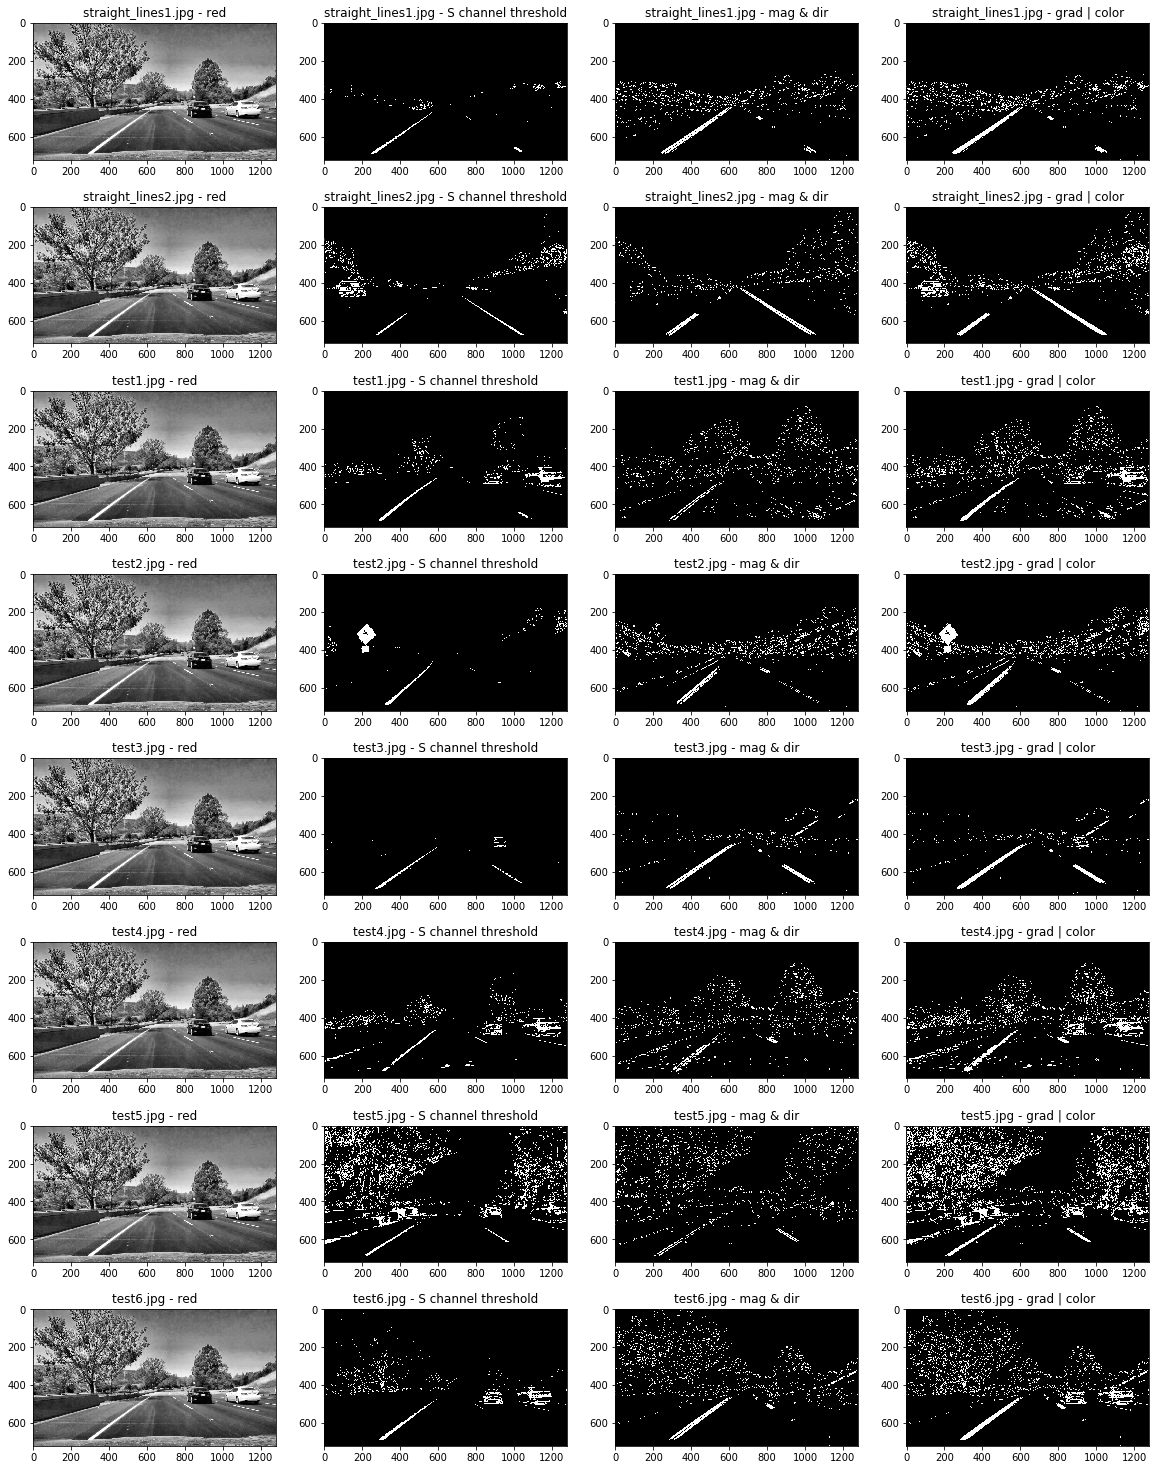

In [397]:
image_path_pattern = os.path.join(root_folder, "data", "test_images", "*.jpg")
image_fnames = glob.glob(image_path_pattern)

plotter = Plotter(columns=4, figsize=(20, 40))

for i, img_fname in enumerate(image_fnames):
    img = mpimg.imread(img_fname)
    
    # Undistort Image
    mtx_filename  = os.path.join(root_folder, "params", "camera_matrix.npy")
    dist_filename = os.path.join(root_folder, "params", "dist_coeffs.npy")
    img = apply_precomputed_undistortion(img, mtx_filename, dist_filename)
    
    red = img[:, :, 0]
    plotter.add_img(cl1, "%s - red" % os.path.basename(img_fname))
    
    # Saturation-based thresholding
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls_img[:, :, 2]
    
    s_thresh_value = 150
    s_thresh = np.zeros_like(s_channel)
    s_thresh[s_channel > s_thresh_value] = 1
    plotter.add_img(s_thresh, "%s - S channel threshold" % os.path.basename(img_fname))
    
    # Direction-based thresholding
    sobel_kernel = 25
    assert sobel_kernel >= 3 and sobel_kernel % 2 == 1
    sobel_x = cv2.Sobel(red, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(red, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    sobel_x = np.absolute(sobel_x)
    sobel_y = np.absolute(sobel_y)

    # Magnitude
    magnitude = (sobel_x**2 + sobel_y**2)**.5
    mag_norm = np.uint8(255 * magnitude / np.max(magnitude))
    mag_thresh_value = 30
    mag_thresh = np.zeros_like(mag_norm, dtype=np.uint8)
    mag_thresh[mag_norm > mag_thresh_value] = 1
    
    # Direction
    atan = np.arctan2(sobel_y, sobel_x)
    atan_thresh_min = 0.8
    atan_thresh_max = 1.2
    dir_thresh = np.zeros_like(atan, dtype=np.uint8)
    dir_thresh[(atan > atan_thresh_min) & (atan <= atan_thresh_max)] = 1
    
    # Combinations
    mag_and_dir = cv2.bitwise_and(mag_thresh, dir_thresh)
    plotter.add_img(mag_and_dir, "%s - mag & dir" % os.path.basename(img_fname))
    
    grad_or_color = cv2.bitwise_or(mag_and_dir, s_thresh)
    plotter.add_img(grad_or_color, "%s - grad | color" % os.path.basename(img_fname))
    
plotter.plot()


#### Application
I am dissatisfied with the thresholding still. When no lines are present on the right, It will be very hard to detect anything. But we'll see how it goes - there are many ways to tweak the system still. Lets now create the thresholding function.

In [75]:
def process_img(img):
    # Undistort Image
    mtx_filename  = os.path.join(root_folder, "params", "camera_matrix.npy")
    dist_filename = os.path.join(root_folder, "params", "dist_coeffs.npy")
    img = apply_precomputed_undistortion(img, mtx_filename, dist_filename)
    
    # Saturation-based thresholding
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls_img[:, :, 2]
    
    s_thresh_value = 150
    s_thresh = np.zeros_like(s_channel)
    s_thresh[s_channel > s_thresh_value] = 1
    
    # Edge Detection
    red = img[:, :, 0]
    sobel_kernel = 25
    assert sobel_kernel >= 3 and sobel_kernel % 2 == 1
    sobel_x = cv2.Sobel(red, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(red, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    sobel_x = np.absolute(sobel_x)
    sobel_y = np.absolute(sobel_y)

    # Magnitude
    magnitude = (sobel_x**2 + sobel_y**2)**.5
    mag_norm = np.uint8(255 * magnitude / np.max(magnitude))
    mag_thresh_value = 30
    mag_thresh = np.zeros_like(mag_norm, dtype=np.uint8)
    mag_thresh[mag_norm > mag_thresh_value] = 1
    
    # Direction
    atan = np.arctan2(sobel_y, sobel_x)
    atan_thresh_min = 0.8
    atan_thresh_max = 1.2
    dir_thresh = np.zeros_like(atan, dtype=np.uint8)
    dir_thresh[(atan > atan_thresh_min) & (atan <= atan_thresh_max)] = 1
    
    # Combinations
    mag_and_dir = cv2.bitwise_and(mag_thresh, dir_thresh)    
    grad_or_color = cv2.bitwise_or(mag_and_dir, s_thresh)
    
    return grad_or_color